In [ ]:
!pip install patchify
!pip install split-folders
!pip install rasterio[s3]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 1.3 MB/s 
     |████████████████████████████████| 132 kB 70.0 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 10.3 MB 52.9 MB/s 
     |████████████████████████████████| 140 kB 67.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have u

In [ ]:
import os # working with files/directories
import shutil # working with files/directories
import random

import cv2
import rasterio
from rasterio.plot import show

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

from patchify import patchify  #  cropping images
from patchify import unpatchify
import splitfolders #  splitting images to train/val folders

from tensorflow.keras.utils import to_categorical  # labels encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator # with datagenerator we don't keep the whole train data in RAM

from keras.models import Model  # UNET
from keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
if 'images' and 'masks' not in os.listdir():
    !wget https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip
    !unzip landcover.ai.v1.zip
    !rm landcover.ai.v1.zip
print('Files are ready to be used.')
    
os.listdir()

--2022-12-20 18:13:38--  https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip
Resolving landcover.ai.linuxpolska.com (landcover.ai.linuxpolska.com)... 95.216.226.136
Connecting to landcover.ai.linuxpolska.com (landcover.ai.linuxpolska.com)|95.216.226.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1538212277 (1.4G) [application/zip]
Saving to: ‘landcover.ai.v1.zip’

landcover.ai.v1.zip 100%[===================>]   1.43G  18.0MB/s    in 82s     

2022-12-20 18:15:01 (17.9 MB/s) - ‘landcover.ai.v1.zip’ saved [1538212277/1538212277]

Archive:  landcover.ai.v1.zip
   creating: images/
  inflating: images/M-33-48-A-c-4-4.tif  
  inflating: images/M-33-20-D-c-4-2.tif  
  inflating: images/M-33-20-D-d-3-3.tif  
  inflating: images/M-33-32-B-b-4-4.tif  
  inflating: images/M-33-7-A-d-2-3.tif  
  inflating: images/M-33-7-A-d-3-2.tif  
  inflating: images/M-34-32-B-a-4-3.tif  
  inflating: images/M-34-32-B-b-1-3.tif  
  inflating: images/M-34-5-D-d-4-2.

['.config',
 'train.txt',
 'test.txt',
 'images',
 'val.txt',
 'masks',
 'split.py',
 'sample_data']

In [ ]:
!rm 'train.txt', 'split.py', 'test.txt', 'val.txt'

rm: cannot remove 'train.txt,': No such file or directory
rm: cannot remove 'split.py,': No such file or directory
rm: cannot remove 'test.txt,': No such file or directory


In [ ]:
image_names = os.listdir('images')
mask_names = os.listdir('masks')

In [ ]:
print(f"Number of images: {len(image_names)}")
print(f"Number of masks: {len(mask_names)}")

Number of images: 41
Number of masks: 41


In [ ]:
name = image_names[0]
src = rasterio.open('images'+'/'+name)

print('File name: ' + src.name)
print(f'Number of channels: {src.count}')
print(f'Size: {src.width}x{src.height}')
print(f'Bounds: {src.bounds}')

src.close()

File name: images/N-34-97-D-c-2-4.tif
Number of channels: 3
Size: 4230x4672
Bounds: BoundingBox(left=456014.49999953725, bottom=575323.9998759776, right=458129.49999953725, top=577659.9998759776)


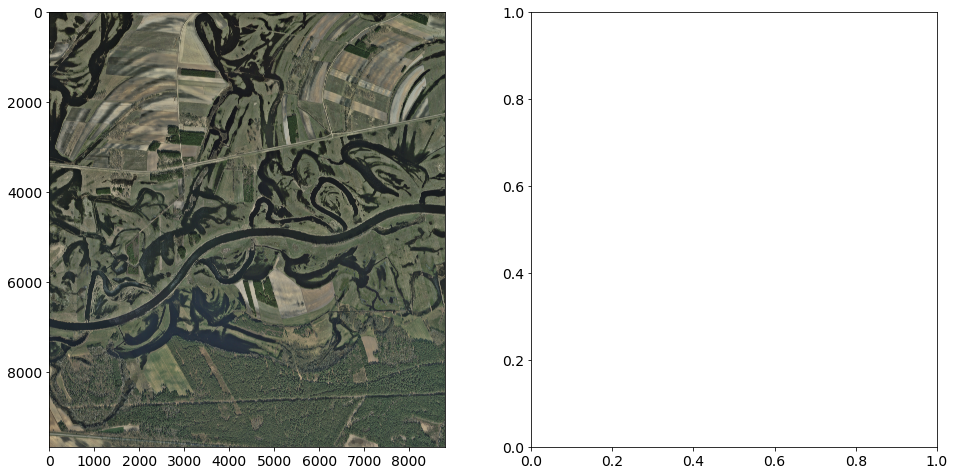

In [ ]:
labels = {0: 'None',
          1: 'building',
          2: 'woodland',
          3: 'water',
          4: 'road'} # from dataset website

index = random.randint(0,len(image_names)-1) # choose random image name
name = image_names[index]

fig, axs = plt.subplots(1, 2, figsize=(16,8))

with rasterio.open('images'+'/'+name) as src:
    image = src.read().transpose(1,2,0) 
    axs[0].imshow(image) # show image
    
with rasterio.open('masks'+'/'+name) as src:
    mask = src.read().transpose(1,2,0)
    # im = axs[1].imshow(mask)  # show mask
    
    # colors = [im.cmap(im.norm(value)) for value in labels.keys()] # colors from imshow
    # patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels.keys()))] # creating legend info
    # plt.legend(handles=patches) # add legend with labels

plt.show()

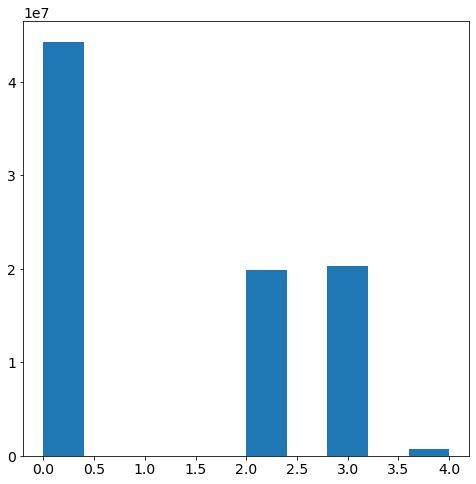

In [ ]:
plt.figure(figsize=(8,8))
plt.hist(mask.flatten())
plt.show()

In [ ]:
os.makedirs("256_patches/images")
os.makedirs("256_patches/masks")

In [ ]:
def create_patches(input_folder, output_folder, patch_size = 256, datatype = 'image'):
    '''Crop images/masks from input_folder/ and save pathces (patch_size*patch_size) to output_folder/.
    Also works with images in subdirs.
    
    input_folder -- relative path to images source folder ('folder/../../')
    output_folder -- relative path to patches destination folder ('folder/../../')
    patch_size -- size of pathes (default 256). Recommended: 64/128/256/512
    datatype -- "image"" or "mask" (default 'image'), affects cv2_readmode
    '''
    
    if datatype == 'image':
        cv2_readmode = 1 # BGR readmode
    elif datatype == 'mask':
        cv2_readmode = 0 # Gray readmode
    else:
        print("Please, specify correct datatype: image or mask")
        print("Patches haven't been created.")
        return 0

    # Go through all subdirs and choose each read each image/mask
    for path, subdirs, files in os.walk(input_folder):
        names = os.listdir(path)
        for k, name in enumerate(names):
            if name.endswith(".tif"):
                # Read image/mask
                image = cv2.imread(path+"/"+name, cv2_readmode)
                print(f"Processing {k}nd {datatype} {name} with shape: {image.shape}.")
                
                # Crop image/mask
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                image = image[:SIZE_Y, :SIZE_X] 
                
                # Create and save patches for image/mask (same algorithm but different shapes)
                if datatype == 'image':
                    patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                    for i in range(patches.shape[0]): 
                        for j in range(patches.shape[1]):
                            single_patch = patches[i,j,0,:,:]
                            cv2.imwrite(output_folder+name.split('.', 1)[0]+"_patch_"+str(i)+str(j)+".tif",
                                        single_patch)
                elif datatype == 'mask':
                    patches = patchify(image, (patch_size, patch_size), step=patch_size)
                    for i in range(patches.shape[0]): 
                        for j in range(patches.shape[1]):
                            single_patch = patches[i,j]
                            cv2.imwrite(output_folder+name.split('.', 1)[0]+"_patch_"+str(i)+str(j)+".tif",
                                        single_patch)
                
                print(f"{k}nd {datatype} {name} is patched.")

In [ ]:
create_patches('images/', '256_patches/images/', datatype='image')

Processing 0nd image N-34-97-D-c-2-4.tif with shape: (4672, 4230, 3).
0nd image N-34-97-D-c-2-4.tif is patched.
Processing 1nd image N-34-94-A-b-2-4.tif with shape: (9697, 8746, 3).
1nd image N-34-94-A-b-2-4.tif is patched.
Processing 2nd image M-34-6-A-d-2-2.tif with shape: (9470, 8818, 3).
2nd image M-34-6-A-d-2-2.tif is patched.
Processing 3nd image N-33-119-C-c-3-3.tif with shape: (4750, 4352, 3).
3nd image N-33-119-C-c-3-3.tif is patched.
Processing 4nd image N-34-140-A-d-3-4.tif with shape: (9579, 8885, 3).
4nd image N-34-140-A-d-3-4.tif is patched.
Processing 5nd image N-33-96-D-d-1-1.tif with shape: (4699, 4227, 3).
5nd image N-33-96-D-d-1-1.tif is patched.
Processing 6nd image N-34-140-A-d-4-2.tif with shape: (9587, 8889, 3).
6nd image N-34-140-A-d-4-2.tif is patched.
Processing 7nd image M-33-7-A-d-2-3.tif with shape: (9711, 9081, 3).
7nd image M-33-7-A-d-2-3.tif is patched.
Processing 8nd image N-33-60-D-d-1-2.tif with shape: (4697, 4127, 3).
8nd image N-33-60-D-d-1-2.tif is

In [ ]:
create_patches('masks/', '256_patches/masks/', datatype='mask')

Processing 0nd mask N-34-97-D-c-2-4.tif with shape: (4672, 4230).
0nd mask N-34-97-D-c-2-4.tif is patched.
Processing 1nd mask N-34-94-A-b-2-4.tif with shape: (9697, 8746).
1nd mask N-34-94-A-b-2-4.tif is patched.
Processing 2nd mask M-34-6-A-d-2-2.tif with shape: (9470, 8818).
2nd mask M-34-6-A-d-2-2.tif is patched.
Processing 3nd mask N-33-119-C-c-3-3.tif with shape: (4750, 4352).
3nd mask N-33-119-C-c-3-3.tif is patched.
Processing 4nd mask N-34-140-A-d-3-4.tif with shape: (9579, 8885).
4nd mask N-34-140-A-d-3-4.tif is patched.
Processing 5nd mask N-33-96-D-d-1-1.tif with shape: (4699, 4227).
5nd mask N-33-96-D-d-1-1.tif is patched.
Processing 6nd mask N-34-140-A-d-4-2.tif with shape: (9587, 8889).
6nd mask N-34-140-A-d-4-2.tif is patched.
Processing 7nd mask M-33-7-A-d-2-3.tif with shape: (9711, 9081).
7nd mask M-33-7-A-d-2-3.tif is patched.
Processing 8nd mask N-33-60-D-d-1-2.tif with shape: (4697, 4127).
8nd mask N-33-60-D-d-1-2.tif is patched.
Processing 9nd mask M-34-65-D-c-4-2

In [ ]:
num = len(os.listdir('256_patches/images'))
print("Number of images 256x256: " + str(num))

num = len(os.listdir('256_patches/masks'))
print("Number of masks 256x256: " + str(num))

Number of images 256x256: 41646
Number of masks 256x256: 41646


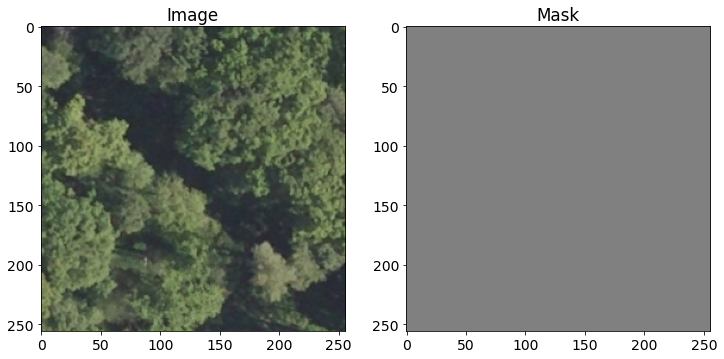

In [ ]:
train_img_dir = "256_patches/images/"
train_mask_dir = "256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')

plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray', vmin=0, vmax=4)
plt.title('Mask')
plt.show()

In [ ]:
img_list.sort()
msk_list.sort()

In [ ]:
os.makedirs("256_patches/images_with_useful_info/images")
os.makedirs("256_patches/images_with_useful_info/masks")

In [ ]:
useless=0  # useless image counter

for index in range(len(img_list)):
    img_name = img_list[index]
    mask_name = msk_list[index]
    
    temp_image=cv2.imread(train_img_dir+img_list[index], 1)
    temp_mask=cv2.imread(train_mask_dir+msk_list[index], 0)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (counts[0]/counts.sum()) > 0.95 and val[0] == 0: # if mask has less than 5% of usefull info we ignore it
        useless +=1
    else:
        cv2.imwrite('256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
  
    if index%1000 == 0:
        print(f'Current index {index}')

print("Total useful images are: ", len(img_list)-useless)
print("Total useless images are: ", useless)

Current index 0
Current index 1000
Current index 2000
Current index 3000
Current index 4000
Current index 5000
Current index 6000
Current index 7000
Current index 8000
Current index 9000
Current index 10000
Current index 11000
Current index 12000
Current index 13000
Current index 14000
Current index 15000
Current index 16000
Current index 17000
Current index 18000
Current index 19000
Current index 20000
Current index 21000
Current index 22000
Current index 23000
Current index 24000
Current index 25000
Current index 26000
Current index 27000
Current index 28000
Current index 29000
Current index 30000
Current index 31000
Current index 32000
Current index 33000
Current index 34000
Current index 35000
Current index 36000
Current index 37000
Current index 38000
Current index 39000
Current index 40000
Current index 41000
Total useful images are:  28210
Total useless images are:  13436


In [ ]:
with rasterio.open('256_patches/images/M-33-20-D-c-4-2_patch_00.tif') as src:
    patch = src.read().transpose(1,2,0)

with rasterio.open('images/M-33-20-D-c-4-2.tif') as src:
    image_part = src.read().transpose(1,2,0)[:256,:256,:]

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


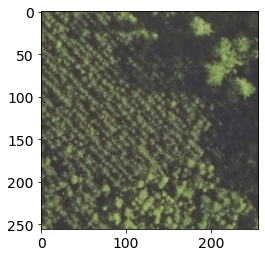

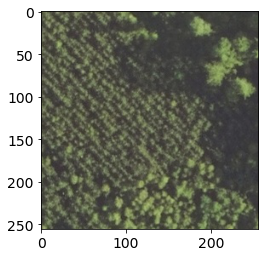

In [ ]:
plt.imshow(patch)
plt.show()
plt.imshow(image_part)
plt.show()

In [ ]:
input_folder = '256_patches/images_with_useful_info/'
output_folder = 'data/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 56420 files [00:55, 1009.79 files/s]


In [ ]:
shutil.rmtree("256_patches")

In [ ]:
for path, subdirs, files in os.walk("data/"):
    print(path)

data/
data/train
data/train/images
data/train/masks
data/val
data/val/images
data/val/masks


In [ ]:
def copy_and_delete(src, dest, path="data/"):
    '''Copies all file from folder /src to /dest. After that delete /src'''
    
    src = path + src
    dest = path + dest
    
    try:
        os.makedirs(dest) # create new folder if doesn't exist
        print(f"Folder {dest} has been created.")
    except:
        print(f"Folder {dest} already exist.")
    
    for file_name in os.listdir(src):
        full_file_name = os.path.join(src, file_name)
        shutil.copy(full_file_name, dest)
    
    shutil.rmtree(src)
    print(f'All files sucesfully coppied and {src} has been removed.')

In [ ]:
copy_and_delete("train/images", "train_images/train")
copy_and_delete("train/masks", "train_masks/train")
copy_and_delete("val/images", "val_images/val")
copy_and_delete("val/masks", "val_masks/val")

Folder data/train_images/train has been created.
All files sucesfully coppied and data/train/images has been removed.
Folder data/train_masks/train has been created.
All files sucesfully coppied and data/train/masks has been removed.
Folder data/val_images/val has been created.
All files sucesfully coppied and data/val/images has been removed.
Folder data/val_masks/val has been created.
All files sucesfully coppied and data/val/masks has been removed.


In [ ]:
# delete empty folders

shutil.rmtree("data/train")
shutil.rmtree("data/val")

In [ ]:
for path, subdirs, files in os.walk("data/"):
    print(path)

data/
data/train_images
data/train_images/train
data/val_images
data/val_images/val
data/train_masks
data/train_masks/train
data/val_masks
data/val_masks/val


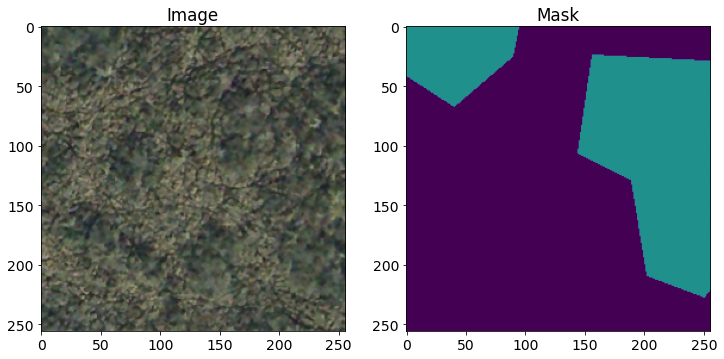

In [ ]:
train_img_dir = "data/train_images/train/"
train_mask_dir = "data/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')

plt.subplot(122)
plt.imshow(mask_for_plot, vmin=0, vmax=4)
plt.title('Mask')
plt.show()

In [ ]:
seed = 24
batch_size = 8
n_classes = 5

In [ ]:
def preprocess_data(img, mask, num_class):
    img = img/255
    mask = to_categorical(mask, num_class)
    
    return (img,mask)

In [ ]:
def trainGenerator(img_path, mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip = True,
                            vertical_flip = True,
                            fill_mode = 'reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_path = "data/train_images/"
train_mask_path = "data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

In [ ]:
val_img_path = "data/val_images/"
val_mask_path = "data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

Found 22568 images belonging to 1 classes.
Found 22568 images belonging to 1 classes.


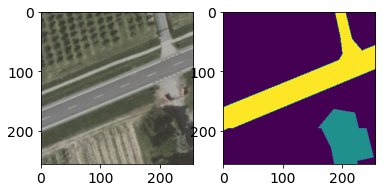

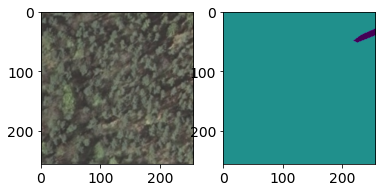

In [ ]:
x, y = train_img_gen.__next__()

for i in range(batch_size//4):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, vmin=0, vmax=4)
    plt.show()

Found 5642 images belonging to 1 classes.
Found 5642 images belonging to 1 classes.


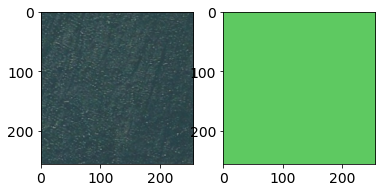

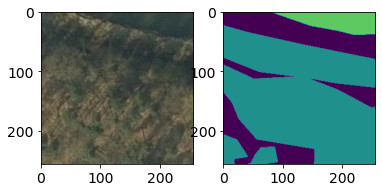

In [ ]:
x_val, y_val = val_img_gen.__next__()

for i in range(batch_size//4):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, vmin=0, vmax=4)
    plt.show()

In [ ]:
num_train_imgs = len(os.listdir('data/train_images/train/'))
num_val_imgs = len(os.listdir('data/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_imgs//batch_size

In [ ]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
n_classes=5

In [ ]:
def multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
model_name = "landcover_10_epochs.hdf5"
!gdown --id 1P2iDTXqzDx22vDDmN9ZKVM48UImhkmWF
check = False

if os.path.exists(model_name):
    model = load_model(model_name)
    print("Model is loaded.")
    check = True
else:
    model = multi_unet_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    print("Model is created.")
print(f"Number of params: {model.count_params()}")

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1P2iDTXqzDx22vDDmN9ZKVM48UImhkmWF
To: /content/landcover_10_epochs.hdf5
100% 23.5M/23.5M [00:00<00:00, 56.6MB/s]
Model is loaded.
Number of params: 1941173


In [ ]:
if not check:
    history = model.fit(train_img_gen,
              steps_per_epoch=steps_per_epoch,
              epochs=30,
              verbose=1,
              validation_data=val_img_gen,
              validation_steps=val_steps_per_epoch)

In [ ]:
model.save("landcover_30_epochs.hdf5")

In [ ]:
if not check:
    plt.figure(figsize=(6,6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='vall_loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

1/1 [==============================] - 10s 10s/step


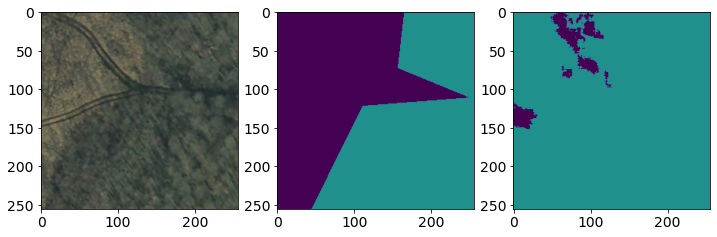

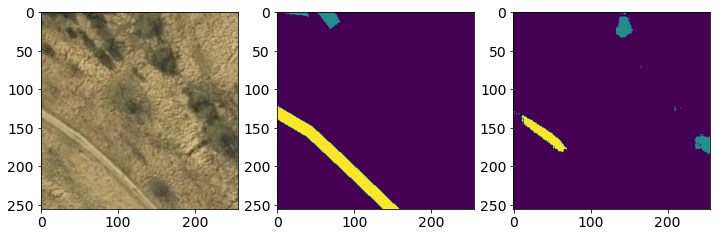

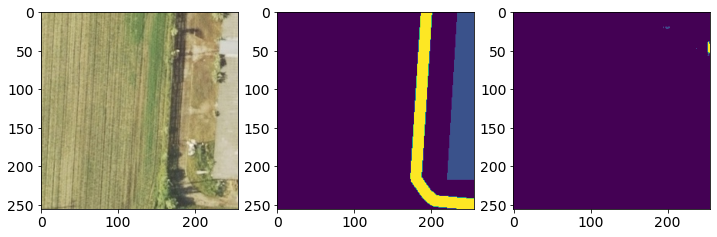

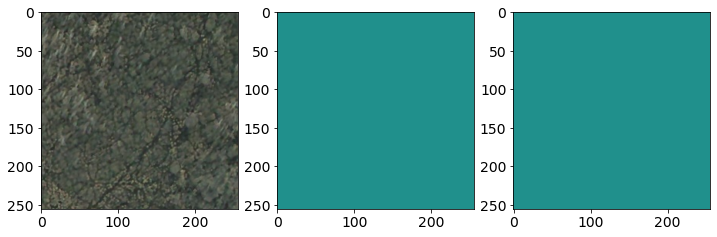

In [ ]:
x, y = train_img_gen.__next__()
predict = model.predict(x)

for i in range(batch_size//2):
    
    plt.figure(figsize=(12,4))
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    predict_mask = np.argmax(predict[i], axis=2)

    plt.subplot(1,3,1)
    plt.imshow(image)
    
    plt.subplot(1,3,2)
    plt.imshow(mask, vmin=0, vmax=4)
    
    plt.subplot(1,3,3)
    plt.imshow(predict_mask, vmin=0, vmax=4)
    
    plt.show()

1/1 [==============================] - 0s 28ms/step
(256, 256, 5)


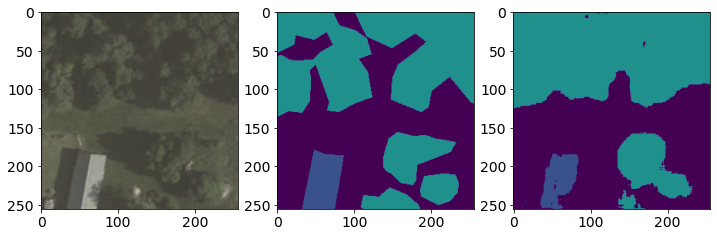

(256, 256, 5)


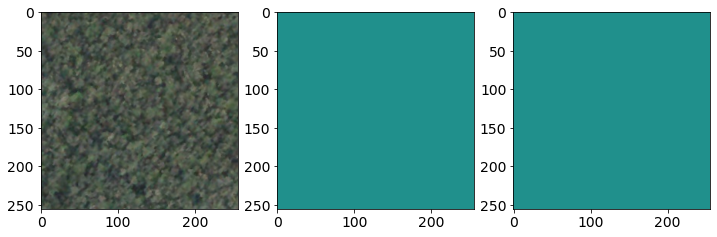

(256, 256, 5)


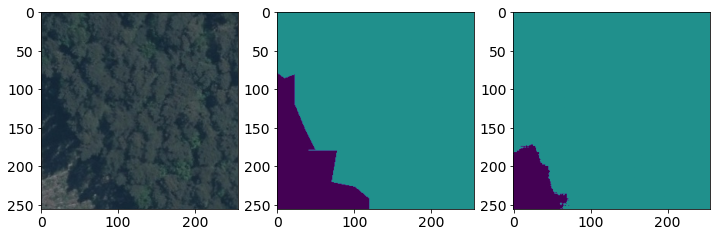

(256, 256, 5)


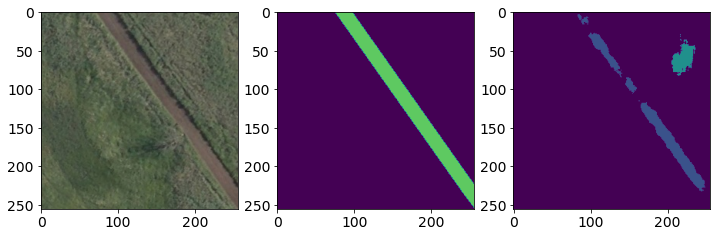

In [ ]:
x, y = val_img_gen.__next__()
predict = model.predict(x)

for i in range(batch_size//2):
    
    plt.figure(figsize=(12,4))
    image = x[i]
    print(y[i].shape)
    mask = np.argmax(y[i], axis=-1)
    predict_mask = np.argmax(predict[i], axis=-1)

    plt.subplot(1,3,1)
    plt.imshow(image)
    
    plt.subplot(1,3,2)
    plt.imshow(mask, vmin=0, vmax=4)
    
    plt.subplot(1,3,3)
    plt.imshow(predict_mask, vmin=0, vmax=4)
    
    plt.show()

In [ ]:
patch_size = 256
name = 'N-34-97-D-c-2-4.tif'

image = cv2.imread('images/' + name, 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255

mask = cv2.imread('masks/' + name, 0)

SIZE_X = (image.shape[1]//patch_size)*patch_size
SIZE_Y = (image.shape[0]//patch_size)*patch_size

image = image[:SIZE_Y, :SIZE_X]
mask = mask[:SIZE_Y, :SIZE_X]
print(mask.shape,image.shape)

patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
patches_mask = np.ones(patchify(mask, (patch_size, patch_size), step=patch_size).shape)*255
print(patches_img.shape, patches_mask.shape)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
            temp_img = patches_img[i,j,:,:,:,:]
            temp_mask = model.predict(temp_img)
            temp_mask = np.argmax(temp_mask, axis = -1)
            patches_mask[i,j] = temp_mask[0,:,:]

mask_predicted = unpatchify(patches_mask, mask.shape).astype(int)

del patches_mask
del patches_img

(4608, 4096) (4608, 4096, 3)
(18, 16, 1, 256, 256, 3) (18, 16, 256, 256)
1/1 [==============================] - 0s 16ms/step


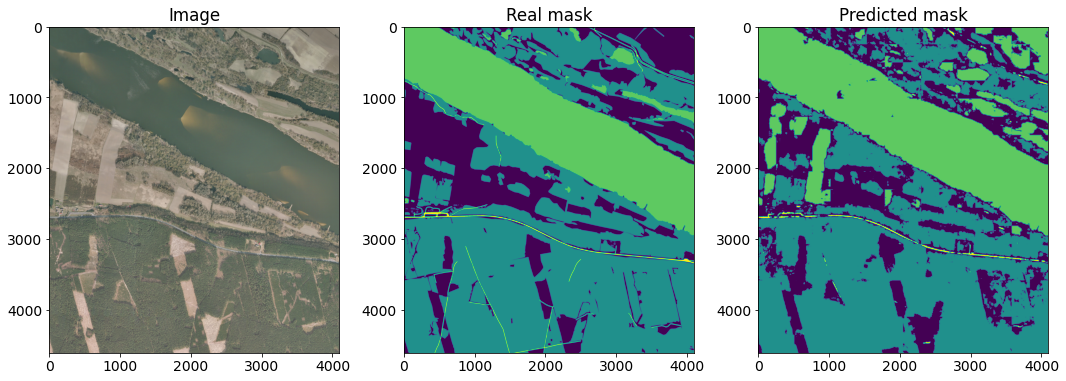

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title('Image')
plt.imshow(image)

plt.subplot(1,3,2)
plt.title('Real mask')
plt.imshow(mask, vmin=0, vmax=4)

plt.subplot(1,3,3)
plt.title('Predicted mask')
plt.imshow(mask_predicted, vmin=0, vmax=4)

plt.show()

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


(12410, 10190, 3)
(5888, 5888) (5888, 5888, 3)
(23, 23, 256, 256) (23, 23, 1, 256, 256, 3)
1/1 [==============================] - 0s 23ms/step


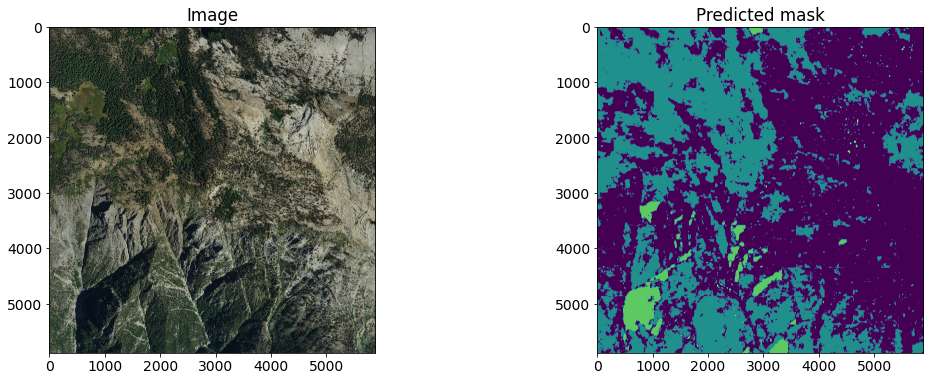

In [ ]:
patch_size = 256
name = '/content/gdrive/MyDrive/NAIP/sample.tif'

image = cv2.imread(name, 1)
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
image = image[2000:8000, 2000:8000,:]

# mask = cv2.imread('masks/' + name, 0)

SIZE_X = (image.shape[1]//patch_size)*patch_size
SIZE_Y = (image.shape[0]//patch_size)*patch_size

image = image[:SIZE_Y, :SIZE_X]
mask = np.zeros([image.shape[0], image.shape[1]])
print(mask.shape, image.shape)

patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
patches_mask = np.ones(patchify(mask, (patch_size, patch_size), step=patch_size).shape)*255
print(patches_mask.shape, patches_img.shape)

for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
            temp_img = patches_img[i,j,:,:,:,:]
            temp_mask = model.predict(temp_img)
            temp_mask = np.argmax(temp_mask, axis = -1)
            patches_mask[i,j] = temp_mask[0,:,:]

mask_predicted = unpatchify(patches_mask, mask.shape).astype(int)

del patches_mask
del patches_img

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title('Image')
plt.imshow(image)

plt.subplot(1,2,2)
plt.title('Predicted mask')
plt.imshow(mask_predicted, vmin=0, vmax=4)

plt.show()

In [ ]:
# name = '/content/gdrive/MyDrive/NAIP/sample.tif'
# image = cv2.imread(name, 1)
# print(image.shape)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255
# plt.imshow(image[2000:8000,2000:8000,:])
# plt.show()

In [ ]:
# correct = 0
# total = 0
# for x,y in val_img_gen:
#     predict = model.predict(x)
#     for i in range(batch_size//2):
#       mask = np.argmax(y[i], axis=-1)
#       predict_mask = np.argmax(predict[i], axis=-1)
#       correct += mask[mask == predict_mask].shape[0]
#       total += mask[mask == mask].shape[0]
  
#       print("Validation Accuracy: ", correct*100/total)

1/1 [==============================] - 0s 24ms/step
Validation Accuracy:  92.15850830078125
Validation Accuracy:  95.74050903320312
Validation Accuracy:  96.2493896484375
Validation Accuracy:  97.18704223632812
1/1 [==============================] - 0s 23ms/step
Validation Accuracy:  97.7496337890625
Validation Accuracy:  97.509765625
Validation Accuracy:  97.14224679129464
Validation Accuracy:  96.74301147460938
1/1 [==============================] - 0s 26ms/step
Validation Accuracy:  96.62458631727431
Validation Accuracy:  96.87301635742188
Validation Accuracy:  97.15728759765625
Validation Accuracy:  96.2689717610677
1/1 [==============================] - 0s 22ms/step
Validation Accuracy:  95.78622671274039
Validation Accuracy:  95.40459769112724
Validation Accuracy:  95.17527262369792
Validation Accuracy:  95.4768180847168
1/1 [==============================] - 0s 28ms/step
Validation Accuracy:  94.79783002068015
Validation Accuracy:  94.90814208984375
Validation Accuracy:  94.5144

IndexError: ignored